In [1]:
#created a directory to store models
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quantization.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [2]:
import tensorflow as tf
from tensorflow import keras
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import math

In [3]:
#setting the seed values
seed =123
np.random.seed(seed)
tf.random.set_seed(seed)

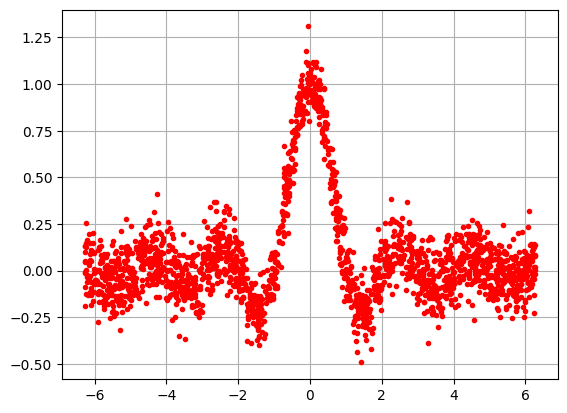

In [7]:
datapoints =2000
x_values = np.random.uniform(low=-1*2*math.pi, high=2*math.pi, size=datapoints).astype(np.float32)
np.random.shuffle(x_values)
y_values = np.sinc(x_values).astype(np.float32)
y_values+=0.1*np.random.randn(*y_values.shape)
plt.plot(x_values, y_values, 'r.')
plt.grid()
plt.show()

In [12]:
TRAIN_SPLIT =  int(0.8 * datapoints)
TEST_SPLIT = int(0.1 * datapoints + TRAIN_SPLIT)

In [13]:
x_train, x_test, x_validate = np.split(x_values, [TRAIN_SPLIT, TEST_SPLIT])
y_train, y_test, y_validate = np.split(y_values, [TRAIN_SPLIT, TEST_SPLIT])
assert (x_train.size + x_validate.size + x_test.size) ==  datapoints #if not raise an assertion error

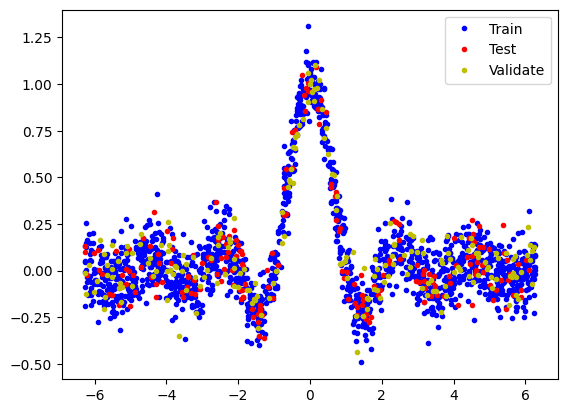

In [14]:
plt.plot(x_train, y_train, 'b.', label="Train")
plt.plot(x_test, y_test, 'r.', label="Test")
plt.plot(x_validate, y_validate, 'y.', label="Validate")
plt.legend()
plt.show()


In [28]:
model = keras.Sequential([
        keras.layers.Dense(16,activation='relu',input_shape = (1,)),
        keras.layers.Dense(16,activation='relu'),
        keras.layers.Dense(1) #linear activation is used for last layer
])

In [29]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 16)                32        
                                                                 
 dense_7 (Dense)             (None, 16)                272       
                                                                 
 dense_8 (Dense)             (None, 1)                 17        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

#metrics for regression ---> mse , mae , mape , cosine
#metrics for classification  ---> accuracy


In [47]:
history = model.fit(x_train, y_train, epochs=500, batch_size=64,verbose=1,
                        validation_data=(x_validate, y_validate))

Epoch 1/500
25/25 [==============================] - 1s 16ms/step - loss: 0.0122 - mae: 0.0886 - val_loss: 0.0108 - val_mae: 0.0821
Epoch 2/500
25/25 [==============================] - 0s 3ms/step - loss: 0.0120 - mae: 0.0876 - val_loss: 0.0108 - val_mae: 0.0822
Epoch 3/500
25/25 [==============================] - 0s 4ms/step - loss: 0.0120 - mae: 0.0876 - val_loss: 0.0114 - val_mae: 0.0838
Epoch 4/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0122 - mae: 0.0883 - val_loss: 0.0107 - val_mae: 0.0819
Epoch 5/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0121 - mae: 0.0880 - val_loss: 0.0117 - val_mae: 0.0854
Epoch 6/500
25/25 [==============================] - 0s 3ms/step - loss: 0.0121 - mae: 0.0875 - val_loss: 0.0119 - val_mae: 0.0864
Epoch 7/500
25/25 [==============================] - 0s 2ms/step - loss: 0.0120 - mae: 0.0876 - val_loss: 0.0110 - val_mae: 0.0828
Epoch 8/500
25/25 [==============================] - 0s 3ms/step - loss: 0.0120 - 

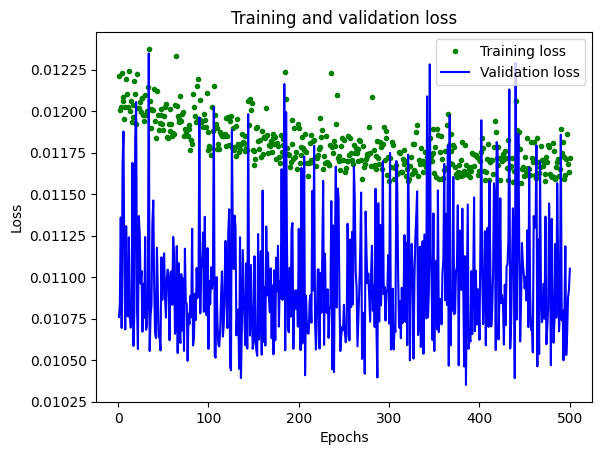

In [48]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

7/7 [==============================] - 0s 1ms/step


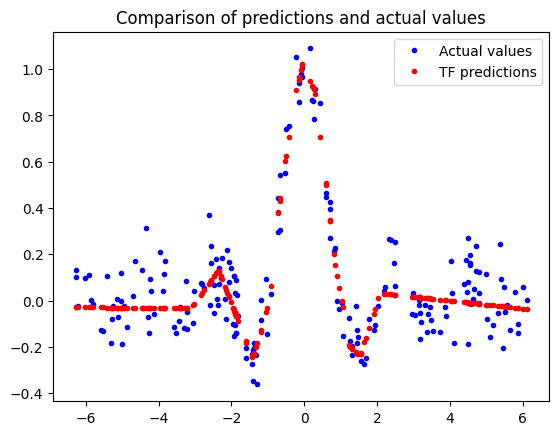

In [49]:
test_loss, test_mae = model.evaluate(x_test, y_test)
y_test_pred = model.predict(x_test)
plt.clf()
plt.title('Comparison of predictions and actual values')
plt.plot(x_test, y_test, 'b.', label='Actual values')
plt.plot(x_test, y_test_pred, 'r.', label='TF predictions')
plt.legend()
plt.show()

In [50]:
model.save(MODEL_TF)

INFO:tensorflow:Assets written to: models/model\assets


In [51]:
#converting to tflite model without quantization
converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_TF)
model_no_quant_tflite = converter.convert()

open(MODEL_NO_QUANT_TFLITE, "wb").write(model_no_quant_tflite)

3192

In [52]:
#converting to tflite with optimization
def representative_dataset():
  for i in range(500):
    yield([x_train[i].reshape(1, 1)])

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

converter.representative_dataset = representative_dataset
model_tflite = converter.convert()

open(MODEL_TFLITE, "wb").write(model_tflite)

2680